<a href="https://colab.research.google.com/github/cc-ats/mlp_tutorial/blob/main/Lesson3_BP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Behler-Parrinello  Symmetry Functions

In this tutorial, we will create Behler-Parrinello and ANI neural networks using atom-centered symmetry functions. The symmetry functions will allow us to ensure that the observables (such as energy) are invariant to translations and rotations.

## Importing PyTorch and Libraries

We begin by importing PyTorch and required libraries.



In [ ]:
%%capture
!pip install pytorch-lightning > /dev/null   #installing PyTorch lightning

import math
from typing import Sequence, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

from torch.utils.data import TensorDataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers

## Symmetry Functions

We have been using Cartesian coordinates $(x,y)$ with the Mueller-Brown potential as training data for the machine learning models. However, Cartesian coordinates are not ideal for use with neural networks because translating or rotating the molecule can change the neural network output. In the case of chemistry this would imply that translating a molecule in space changes the molecule's energy, which is incorrect.

Instead, we can describe the Cartesian coordinates with symmetry functions and use the newly transformed coordinates as inputs, which will produce outputs that are invariant to translations and rotations.

A cutoff function and several symmetry functions were introduced by Behler and Parrinello in 2007 (https://doi.org/10.1103/PhysRevLett.98.146401).

The cutoff function is defined as:  

$$\begin{align}
        f_c(R_{ij}) = \left\{
        \begin{array}{cl}
        0.5\times\left[\cos\left(\frac{\pi R_{ij}}{R_c}\right)+1\right] & \textrm{for } R_{ij} \le R_c \\
        0 & \textrm{for } R_{ij} \gt R_c
        \end{array}
        \right.
\end{align}$$

where $R_{ij}$ is the distance between atoms $i$ and $j$ and $R_c$ is the cutoff distance.  
The radial symmetry function can be defined as:

$$\begin{align}
\begin{array}{c}
G_i^1 = \sum_{j \neq i}^{all} e^{-\eta(R_{ij}-R_s)^2}f_c(R_{ij})
\end{array}
\end{align}$$

Where $\eta$ changes the width of the Gaussian distribution and $R_s$ shifts the center of the Gaussian peak.  

The angular symmetry function can be defined as:

$$\begin{align}
\begin{array}{c}
G_i^2 = 2^{1-\zeta}\sum_{j,k\neq i}^{all} (1+\lambda \cos\theta_{ijk})^\zeta \times e^{-\eta(R_{ij}^2+R_{ik}^2+R_{jk}^2)}f_c(R_{ij}) f_c(R_{ik}) f_c(R_{jk})
\end{array}
\end{align}$$

The angular terms are created for each set of 3 atoms as $\cos\theta_{ijk} = \frac{\mathbf{R_{ij}}\cdot\mathbf{R_{ik}}}{R_{ij}R_{ik}}$, where $\mathbf{R_{ij}} = \mathbf{R_{i}} - \mathbf{R_{j}}$ and gives the distance vector between atoms i and j. The $\lambda$ parameter is set to +1,-1 to allow exploration of the angular environment at the +1 and -1 positions. The parameter $\eta$ changes the width of the Gaussian distribution and $\zeta$ changes the width of the Gaussians in the angular environment.

In 2017, Smith, Isayev, and Roitberg developed the ANAKIN-ME (Accurate NeurAl networK engINe for Molecular Energies), also referred to as ANI (https://doi.org/10.1039/C6SC05720A). ANI uses a modified angular symmetry function defined as:   

$$\begin{align}
\begin{array}{c}
G_i^2 = 2^{1-\zeta}\sum_{j,k\neq i}^{all} (1+\cos(\theta_{ijk}-\theta_s))^\zeta \times e^{-\eta\left(\frac{R_{ij}+R_{ik}}{2}-R_{s}\right)^2}f_c(R_{ij}) f_c(R_{ik})
\end{array}
\end{align}$$

Here, $\theta_s$ is a parameter that allows for shifts in the angular environment and $R_s$ allows for calculating the angular environment in radial shells by shifting the center of the Gaussians. The result is probing the angular environment at different radial lengths and angles instead of only at $\lambda$ values of +1,-1.

### Defining Symmetry Functions

Now we will define the radial symmetry functions:

- **pairwise_vector:** Distance function for calculating distances between each atom.

- **symmetry_function_g1:** BP radial symmetry function.

- **symmetry_function_g2:** BP angular symmetry function.

- **symmetry_function_g2ani:** ANI angular symmetry function.



In [ ]:
def pairwise_vector(coords: Tensor) -> Tensor:
    num_batches, num_channels, _ = coords.size()
    rij = coords[:, :, None] - coords[:, None]
    mask = ~torch.eye(num_channels, dtype=torch.bool, device=coords.device) # remove self-interaction
    rij = torch.masked_select(rij, mask.unsqueeze(2)).view(num_batches, num_channels, num_channels - 1, 3)
    return rij


def symmetry_function_g1(rij: Tensor, Rcr: float, EtaR: Tensor, ShfR: Tensor) -> Tensor:
    dij = torch.norm(rij, dim=3)
    fij = (torch.cos(dij / Rcr * math.pi) + 1) * 0.5 *(dij <= Rcr)
    g1 = torch.sum(torch.exp(-EtaR.unsqueeze(dim=1) * (dij.unsqueeze(dim=-1) - ShfR.unsqueeze(dim=1))**2) * fij.unsqueeze(dim=-1), dim=2)
    return g1


def symmetry_function_g2(rij: Tensor, Rca: float, Zeta: Tensor, EtaA: Tensor, LamA: Tensor) -> Tensor:
    c = torch.combinations(torch.arange(rij.size(2)), r=2)
    rij = rij[:, :, c]
    r12 = rij[:, :, :, 0]
    r13 = rij[:, :, :, 1]
    r23 = r12 - r13
    d12 = torch.norm(r12, dim=3)
    d13 = torch.norm(r13, dim=3)
    d23 = torch.norm(r23, dim=3)
    f12 = (torch.cos(d12 / Rca * math.pi) + 1) * 0.5
    f13 = (torch.cos(d13 / Rca * math.pi) + 1) * 0.5
    f23 = (torch.cos(d23 / Rca * math.pi) + 1) * 0.5
    cosine = torch.einsum('ijkl,ijkl->ijk', r12, r13) / (d12 * d13)

    g2 = torch.sum(2**(1 - Zeta.unsqueeze(dim=1)) * (1 + LamA.unsqueeze(dim=1) * cosine.unsqueeze(dim=-1))**Zeta.unsqueeze(dim=1) * torch.exp(-EtaA.unsqueeze(dim=1) * (d12**2 + d13**2 + d23**2).unsqueeze(dim=-1)) * (f12 * f13 * f23).unsqueeze(dim=-1), dim=2)
    return g2


def symmetry_function_g2ani(rij: Tensor, Rca: float, Zeta: Tensor, ShfZ: Tensor, EtaA: Tensor, ShfA: Tensor) -> Tensor:
    c = torch.combinations(torch.arange(rij.size(2)), r=2)
    rij = rij[:, :, c]
    r12 = rij[:, :, :, 0]
    r13 = rij[:, :, :, 1]
    r23 = r12 - r13
    d12 = torch.norm(r12, dim=3)
    d13 = torch.norm(r13, dim=3)
    f12 = (torch.cos(d12 / Rca * math.pi) + 1) * 0.5
    f13 = (torch.cos(d13 / Rca * math.pi) + 1) * 0.5
    cosine = torch.einsum('ijkl,ijkl->ijk', r12, r13) / (d12 * d13)
    cosine = torch.cos(torch.acos(cosine).unsqueeze(dim=-1) - ShfA.unsqueeze(dim=1))

    g2 = torch.sum(2**(1 - Zeta.unsqueeze(dim=1)) * (1 + cosine)**Zeta.unsqueeze(dim=1) * torch.exp(-EtaA.unsqueeze(dim=1) * (0.5 * (d12 + d13).unsqueeze(dim=-1) - ShfZ.unsqueeze(dim=1))**2) * (f12 * f13).unsqueeze(dim=-1), dim=2)
    return g2

## Defining Neural Network and Feature Extraction Classes

We will now define feature extraction classes which will be used in our Behler-Parrinello and ANI neural networks.


### Defining Sequential and Dense Classes

The Sequential class contains the function for the feed-forward aspect of our neural network.
The Dense class contains functions to describe a densely connected neural network.

In [ ]:
class Sequential(nn.Sequential):
    def forward(self, input: Tuple[Tensor, Tensor]) -> Tuple[Tensor, Tensor]:
        for module in self:
            input = module(input)
        return input

class Dense(nn.Module):
    def __init__(self, num_channels: int, in_features: int, out_features: int, bias: bool = True, activation: bool = False, residual: bool = False) -> None:
        super().__init__()
        self.num_channels = num_channels
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(num_channels, out_features, in_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(num_channels, out_features))
        else:
            self.register_parameter('bias', None)
        self.activation = activation
        self.residual = residual
        self.reset_parameters()

    def reset_parameters(self) -> None:
        for w in self.weight:
            nn.init.kaiming_uniform_(w, a=math.sqrt(5))
        if self.bias is not None:
            for b, w in zip(self.bias, self.weight):
                fan_in, _ = nn.init._calculate_fan_in_and_fan_out(w)
                bound = 1 / math.sqrt(fan_in)
                nn.init.uniform_(b, -bound, bound)

    def forward(self, input: Tuple[Tensor, Tensor]) -> Tuple[Tensor, Tensor]:
        x, channels = input
        weight: Tensor = self.weight[channels]
        output: Tensor = torch.bmm(x.transpose(0, 1), weight.transpose(1, 2)).transpose(0, 1)

        if self.bias is not None:
            bias = self.bias[channels]
            output = output + bias

        if self.activation:
            output = torch.tanh(output)

        if self.residual:
            if output.shape[2] == x.shape[2]:
                output = output + x
            elif output.shape[2] == x.shape[2] * 2:
                output = output + torch.cat([x, x], dim=2)
            else:
                raise NotImplementedError("Not implemented")

        return output, channels

    def extra_repr(self) -> str:
        return 'num_channels={}, in_features={}, out_features={}, bias={}, activation={}, residual={}'.format(
            self.num_channels, self.in_features, self.out_features, self.bias is not None, self.activation, self.residual
        )

### Creating the Feature Class

Now we will create the feature class, which takes input information and uses functions to extract characteristics unique to the called input features. Here we will be using the previously defined symmetry functions for feature extraction.

In [ ]:
class Feature(nn.Module):
    def __init__(self, Rcr: float, EtaR: Tensor, ShfR: Tensor, Rca: float, Zeta: Tensor, EtaA: Tensor, LamA: Tensor) -> None:
        super().__init__()
        assert len(EtaR) == len(ShfR)
        assert len(Zeta) == len(EtaA)
        self.Rcr = Rcr
        self.Rca = Rca
        self.EtaR = torch.Tensor(EtaR)
        self.ShfR = torch.Tensor(ShfR)
        self.Zeta = torch.Tensor(Zeta)
        self.EtaA = torch.Tensor(EtaA)
        self.LamA = torch.Tensor(LamA)

    def forward(self, coords: Tensor, atom_types: Tensor) -> Tensor:
        num_batches, num_channels, _ = coords.size()
        rij = pairwise_vector(coords)
        EtaR = self.EtaR.to(device=coords.device)[atom_types]
        ShfR = self.ShfR.to(device=coords.device)[atom_types]
        Zeta = self.Zeta.to(device=coords.device)[atom_types]
        EtaA = self.EtaA.to(device=coords.device)[atom_types]
        LamA = self.LamA.to(device=coords.device)[atom_types]
        g1 = symmetry_function_g1(rij, self.Rcr, EtaR, ShfR)
        g2 = symmetry_function_g2(rij, self.Rca, Zeta, EtaA, LamA)

        return torch.concat((g1, g2), dim=2)

    @property
    def output_length(self) -> int:
        return len(self.EtaR[0]) + len(self.EtaA[0])

### Creating the Feature Class for ANI

We will create a similar feature class for ANI that uses the ANI angle symmetry function.

In [ ]:
class FeatureANI(nn.Module):
    def __init__(self, Rcr: float, EtaR: Tensor, ShfR: Tensor, Rca: float, Zeta: Tensor, ShfZ: Tensor, EtaA: Tensor, ShfA: Tensor) -> None:
        super().__init__()
        assert len(EtaR) == len(ShfR)
        assert len(Zeta) == len(ShfZ) == len(EtaA) == len(ShfA)
        self.Rcr = Rcr
        self.Rca = Rca
        self.EtaR = torch.Tensor(EtaR)
        self.ShfR = torch.Tensor(ShfR)
        self.Zeta = torch.Tensor(Zeta)
        self.ShfZ = torch.Tensor(ShfZ)
        self.EtaA = torch.Tensor(EtaA)
        self.ShfA = torch.Tensor(ShfA)

    def forward(self, coords: Tensor, atom_types: Tensor) -> Tensor:
        num_batches, num_channels, _ = coords.size()
        rij = pairwise_vector(coords)
        EtaR = self.EtaR.to(device=coords.device)[atom_types]
        ShfR = self.ShfR.to(device=coords.device)[atom_types]
        Zeta = self.Zeta.to(device=coords.device)[atom_types]
        ShfZ = self.ShfZ.to(device=coords.device)[atom_types]
        EtaA = self.EtaA.to(device=coords.device)[atom_types]
        ShfA = self.ShfA.to(device=coords.device)[atom_types]
        g1 = symmetry_function_g1(rij, self.Rcr, EtaR, ShfR)
        g2 = symmetry_function_g2ani(rij, self.Rca, Zeta, ShfZ, EtaA, ShfA)

        return torch.concat((g1, g2), dim=2)

    @property
    def output_length(self) -> int:
        return len(self.EtaR[0]) + len(self.EtaA[0])

### Creating the Fitting Class

Now we create the fitting class, which will use the dense neural network for fitting.


In [ ]:
class Fitting(nn.Module):
    def __init__(self, n_types: int, in_features: int, neuron: Sequence[int] = [240, 240, 240]) -> None:
        super().__init__()
        layers = [Dense(n_types, in_features, neuron[0], activation=True)]
        for i in range(len(neuron)-1):
            layers.append(Dense(n_types, neuron[i], neuron[i+1], activation=True, residual=True))  # iterating through the neurons
        layers.append(Dense(n_types, neuron[-1], 1))
        self.fitting_net = Sequential(*layers)

    def forward(self, input : Tuple[Tensor, Tensor]) -> Tensor:
        output, _ = self.fitting_net(input)
        return output

### Create the Behler-Parrinello Neural Network (BPNN) Class

Finally, we will now create the BPNN class that can be used for training with the symmetry functions.

In [ ]:
class BPNN(pl.LightningModule):
    def __init__(self, descriptor: nn.Module, fitting_net: nn.Module, learning_rate=5e-4) -> None:
        super().__init__()
        self.descriptor = descriptor
        self.fitting_net = fitting_net
        self.learning_rate = learning_rate

    def forward(self, coords: torch.Tensor, atom_types: torch.Tensor):
        coords.requires_grad_()
        descriptors = self.descriptor(coords, atom_types)
        atomic_energies = self.fitting_net((descriptors, atom_types))
        energy = torch.unbind(torch.sum(atomic_energies, dim=1))
        gradient, = torch.autograd.grad(energy, [coords], create_graph=True)
        return torch.hstack(energy), gradient

    def training_step(self, batch, batch_idx):
        qm_coord, atom_types, energy, gradient = batch
        ene_pred, grad_pred = self(qm_coord, atom_types[0]) # training the energy and gradient predictions
        ene_loss = F.mse_loss(ene_pred, energy)   # defining loss functions for energy and gradient predictions
        grad_loss = F.mse_loss(grad_pred, gradient)

        lr = self.optimizers().optimizer.param_groups[0]['lr']
        start_lr = self.optimizers().optimizer.param_groups[0]['initial_lr']
        w_ene = 1
        w_grad = 1 + 99 * (lr / start_lr)

        loss = w_ene / (w_ene + w_grad) * ene_loss + w_grad / (w_ene + w_grad) * grad_loss
        self.log('train_loss', loss)
        self.log('l2_trn', torch.sqrt(loss))
        self.log('l2_e_trn', torch.sqrt(ene_loss))
        self.log('l2_f_trn', torch.sqrt(grad_loss))
        return loss

    def validation_step(self, batch, batch_idx):
        torch.set_grad_enabled(True)
        qm_coord, atom_types, energy, gradient = batch
        ene_pred, grad_pred = self(qm_coord, atom_types[0])
        ene_loss = F.mse_loss(ene_pred, energy)
        grad_loss = F.mse_loss(grad_pred, gradient)

        lr = self.optimizers().optimizer.param_groups[0]['lr']
        start_lr = self.optimizers().optimizer.param_groups[0]['initial_lr']
        w_ene = 1
        w_grad = 1 + 99 * (lr / start_lr)

        loss = w_ene / (w_ene + w_grad) * ene_loss + w_grad / (w_ene + w_grad) * grad_loss
        self.log('val_loss', loss)
        self.log('l2_tst', torch.sqrt(loss))
        self.log('l2_e_tst', torch.sqrt(ene_loss))
        self.log('l2_f_tst', torch.sqrt(grad_loss))
        self.log('lr', lr)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = {'scheduler': torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95),
                     'interval': 'epoch',
                     'frequency': 10,
                    }
        return [optimizer], [scheduler]

## Loading Data

 Files from GitHub:
 - Coordinates and atom types:
- **qm_coord.npy** (1800, 14, 3)
- **qm_elem.txt** ([6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
 - PM3 energies and gradients:
- **energy_sqm.npy** (1800,)
- **qm_grad_sqm.npy** (1800, 14, 3)

 - B3LYP/6-31+G* energies and gradients:
- **energy.npy**  (1800,)
- **qm_grad.npy** (1800, 14, 3)

These files will provide us with semi-empirical (PM3) and QM (B3LYP/6-31+G*) data to train our machine learning model.

In [ ]:
import numpy as np

ds = np.DataSource(None)
qm_coord = np.array(np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Butane/qm_coord.npy", "rb")), dtype="float32")
atom_types = np.loadtxt(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Butane/qm_elem.txt", "r"), dtype=int)
elems = np.unique(atom_types).tolist()
atom_types = np.array([[elems.index(i) for i in atom_types]])
atom_types = atom_types.repeat(len(qm_coord), axis=0)

energy = np.array((np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Butane/energy.npy", "rb")) - np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Butane/energy_sqm.npy", "rb"))) * 27.2114 * 23.061, dtype="float32")
energy = energy - energy.mean()
qm_gradient = np.array((np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Butane/qm_grad.npy", "rb")) - np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Butane/qm_grad_sqm.npy", "rb"))) * 27.2114 * 23.061 / 0.529177249, dtype="float32")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

qm_coord = torch.from_numpy(qm_coord).to(device)
atom_types = torch.from_numpy(atom_types).to(device)
energy = torch.from_numpy(energy).to(device)
qm_gradient = torch.from_numpy(qm_gradient).to(device)

pl.seed_everything(2)
dataset = TensorDataset(qm_coord, atom_types, energy, qm_gradient)
train, val = random_split(dataset, [1728, 72])
# Training Set Size: 1728 (96%)
# Test Set Size:       72 ( 4%)
# Data Set Size:     1780
train_loader = DataLoader(train, batch_size=32)
val_loader = DataLoader(val, batch_size=32)

INFO:lightning_fabric.utilities.seed:Global seed set to 2


## Using ANI for Feature Extraction

Here is an example where we use the ANI model for feature extraction. We will use values for the symmetry function parameters from the ASE_ANI model references (https://github.com/isayev/ASE_ANI), which serves as an interface for the TorchANI (https://doi.org/10.1021/acs.jcim.0c00451) software package. The BP parameters in this tutorial are not optimized for this system. The parameters can be optimized following the procedures outlined in https://doi.org/10.1002/qua.24890.



In [ ]:
%%capture
%%time
pl.seed_everything(2)

ani = True

if ani:
  # From TorchANI
  Rcr = 5.2000e+00
  Rca = 3.5000e+00
  EtaR = [1.6000000e+01]
  ShfR = [9.0000000e-01,1.1687500e+00,1.4375000e+00,1.7062500e+00,1.9750000e+00,2.2437500e+00,2.5125000e+00,2.7812500e+00,3.0500000e+00,3.3187500e+00,3.5875000e+00,3.8562500e+00,4.1250000e+00,4.3937500e+00,4.6625000e+00,4.9312500e+00]
  Zeta = [3.2000000e+01]
  ShfZ = [1.9634954e-01,5.8904862e-01,9.8174770e-01,1.3744468e+00,1.7671459e+00,2.1598449e+00,2.5525440e+00,2.9452431e+00]
  EtaA = [8.0000000e+00]
  ShfA = [9.0000000e-01,1.5500000e+00,2.2000000e+00,2.8500000e+00]
  # Make every combination of EtaR and ShfR with meshgrid
  EtaR, ShfR = np.array(np.meshgrid(EtaR, ShfR)).reshape(2, -1)
  # Make every combination of Zeta, ShfZ, EtaA, and ShfA with meshgrid
  Zeta, ShfZ, EtaA, ShfA = np.array(np.meshgrid(Zeta, ShfZ, EtaA, ShfA)).reshape(4, -1)
  EtaR = np.repeat([EtaR], 3, axis=0)
  ShfR = np.repeat([ShfR], 3, axis=0)
  Zeta = np.repeat([Zeta], 3, axis=0)
  ShfZ = np.repeat([ShfZ], 3, axis=0)
  EtaA = np.repeat([EtaA], 3, axis=0)
  ShfA = np.repeat([ShfA], 3, axis=0)
  descriptor = FeatureANI(Rcr, EtaR, ShfR, Rca, Zeta, ShfZ, EtaA, ShfA)
else:
  Rcr = 6.0
  Rca = 6.0
  ShfR = np.zeros((3,6)) # H, C, O
  EtaR = [0.0, 0.04, 0.14, 0.32, 0.71, 1.79]
  EtaR = np.repeat([EtaR], 3, axis=0) # H, C, O
  Zeta = [1, 2, 4, 8, 16, 32, 1, 2, 4, 8, 16, 32]
  Zeta = np.repeat([Zeta], 3, axis=0) # H, C, O
  EtaA = [0.0, 0.04, 0.14, 0.32, 0.71, 1.79, 0.0, 0.04, 0.14, 0.32, 0.71, 1.79]
  EtaA = np.repeat([EtaA], 3, axis=0) # H, C, O
  LamA = [1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1]
  LamA = np.repeat([LamA], 3, axis=0) # H, C, O
  descriptor = Feature(Rcr, EtaR, ShfR, Rca, Zeta, EtaA, LamA)

fitting_net = Fitting(3, descriptor.output_length, neuron=[240, 240, 240])
model = BPNN(descriptor, fitting_net, learning_rate=5e-4)
csv_logger = pl_loggers.CSVLogger('logs_csv/')
trainer = pl.Trainer(max_epochs=500, logger=csv_logger, log_every_n_steps=20, accelerator='auto')

trainer.fit(model, train_loader, val_loader)
model.to(device)

INFO:lightning_fabric.utilities.seed:Global seed set to 2
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type       | Params
-------------------------------------------
0 | descriptor  | FeatureANI | 0     
1 | fitting_net | Fitting    | 383 K 
-------------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.532     Total estimated model params size (MB)
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=500` reached.


## Saving the Model with PyTorch Files and Evaluating the Model's Accuracy Using RMSD


### Saving the Model with PyTorch

The following files will be saved:

**1) model.pt**
- torch.save saves tensors to model.pt

**2) model_script.pt**
- torch.jit.save attempts to preserve the behavior of some operators across PyTorch versions.

Previously saved models can be loaded with:
 - model.load_state_dict(torch.load("model.pt"))
 - torch.jit.load("model_script.pt")


In [ ]:
torch.save(model.state_dict(), 'model.pt')
torch.jit.save(model.to_torchscript(), "model_script.pt")

In [ ]:
ene_pred, grad_pred = model(qm_coord, atom_types[0])

### Plotting RMSD to Evaluate the Energy and Force Predictions of the Model
RMSD for predicted and reference energy and forces are calculated and displayed below.

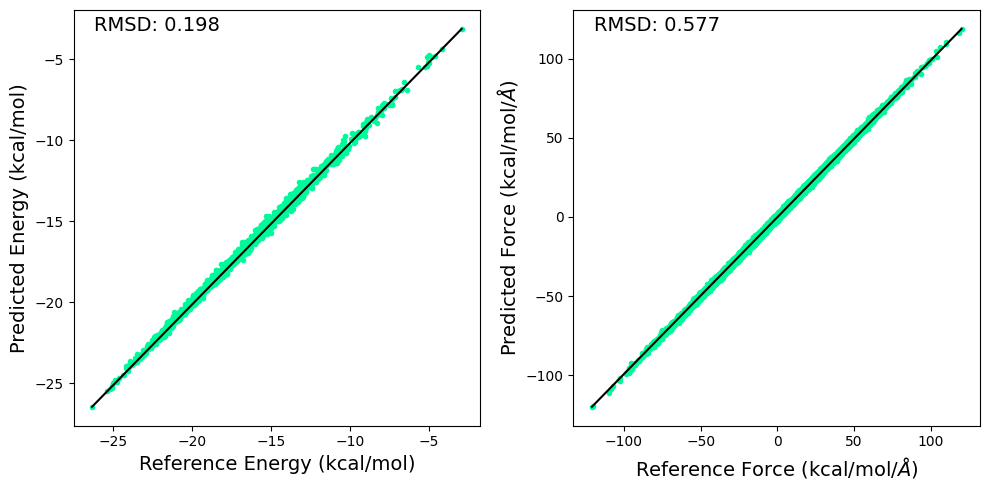

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(10,5))
ds = np.DataSource(None)
e1 = energy.cpu().detach().numpy() + np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Butane/energy_sqm.npy","rb")) * 27.2114 * 23.061
e2 = ene_pred.cpu().detach().numpy() + np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Butane/energy_sqm.npy","rb")) * 27.2114 * 23.061
ax[0].plot(e1, e2, linestyle='none', marker='.',color='mediumspringgreen')
ax[0].plot([np.max(e1), np.min(e1)], [np.max(e2), np.min(e2)] , color="k", linewidth=1.5)
ax[0].set_xlabel("Reference Energy (kcal/mol)", size=14)
ax[0].set_ylabel("Predicted Energy (kcal/mol)", size=14)
ax[0].annotate('RMSD: %.3f' % np.sqrt(np.mean((e1 - e2)**2)), xy=(0.05, 0.95), xycoords='axes fraction', size=14)

f1 = -qm_gradient.cpu().detach().numpy().reshape(-1) - np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Butane/qm_grad_sqm.npy","rb")).reshape(-1) * 27.2114 * 23.061 / 0.529177249
f2 = -grad_pred.cpu().detach().numpy().reshape(-1) - np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Butane/qm_grad_sqm.npy","rb")).reshape(-1) * 27.2114 * 23.061 / 0.529177249

ax[1].plot(f1, f2, linestyle='none', marker='.',color='mediumspringgreen')
ax[1].plot([np.max(f1), np.min(f1)], [np.max(f2), np.min(f2)] , color="k", linewidth=1.5)
ax[1].set_xlabel(r'Reference Force (kcal/mol/$\AA$)', size=14)
ax[1].set_ylabel(r'Predicted Force (kcal/mol/$\AA$)', size=14)
ax[1].annotate('RMSD: %.3f' % np.sqrt(np.mean((f1 - f2)**2)), xy=(0.05, 0.95), xycoords='axes fraction', size=14)

plt.tight_layout()
plt.savefig('rmsd.png', dpi=300)

### The Model Weights and Biases Dictionary

This cell prints the size of the weights and biases used in the trained model for reference.

In [ ]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(f'{param_tensor:<33}\t{model.state_dict()[param_tensor].size()}')

Model's state_dict:
fitting_net.fitting_net.0.weight 	torch.Size([3, 240, 48])
fitting_net.fitting_net.0.bias   	torch.Size([3, 240])
fitting_net.fitting_net.1.weight 	torch.Size([3, 240, 240])
fitting_net.fitting_net.1.bias   	torch.Size([3, 240])
fitting_net.fitting_net.2.weight 	torch.Size([3, 240, 240])
fitting_net.fitting_net.2.bias   	torch.Size([3, 240])
fitting_net.fitting_net.3.weight 	torch.Size([3, 1, 240])
fitting_net.fitting_net.3.bias   	torch.Size([3, 1])


## Plotting the Minimization of the Loss Function


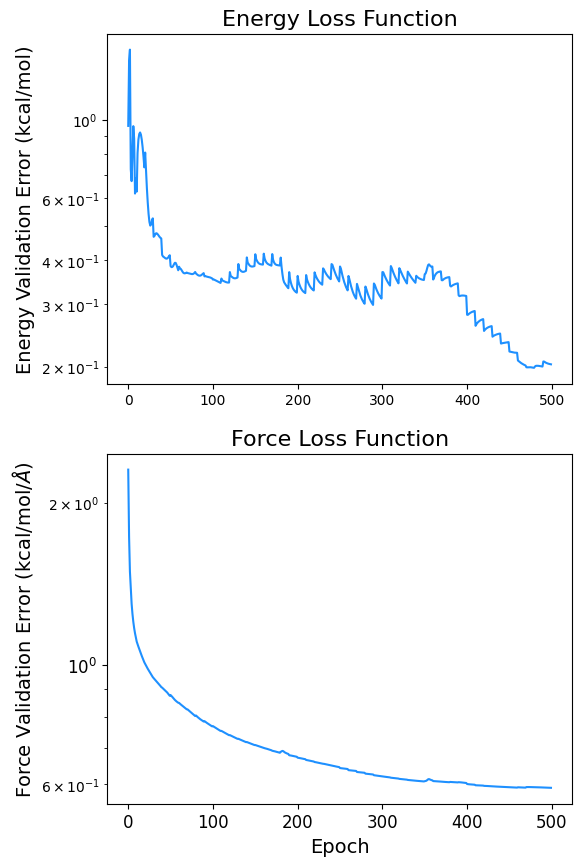

In [ ]:
import pandas as pd

data = pd.read_csv(f'logs_csv/lightning_logs/version_{csv_logger.version}/metrics.csv')
fig, ax = plt.subplots(2, figsize=(6,10))
x = data['epoch'][~data['l2_e_tst'].isnull()]
y = data['l2_e_tst'][~data['l2_e_tst'].isnull()]
y2 = data['l2_f_tst'][~data['l2_f_tst'].isnull()]
ax[0].semilogy(x, y,color='dodgerblue')
ax[0].set_ylabel('Energy Validation Error (kcal/mol)', fontsize=14)
ax[0].set_title('Energy Loss Function', fontsize=16)
ax[1].semilogy(x, y2, label='Force Validation Error (kcal/mol',color='dodgerblue')
ax[1].set_xlabel('Epoch', fontsize=14)
ax[1].set_ylabel(r'Force Validation Error (kcal/mol/$\AA$)', fontsize=14)
ax[1].set_title('Force Loss Function', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.savefig('loss.png', dpi=300)

## Plotting Training and Validation Loss

The loss at each step of the training process is displayed below.

Size of the Training Set: 1350
Size of the Validation Set: 500


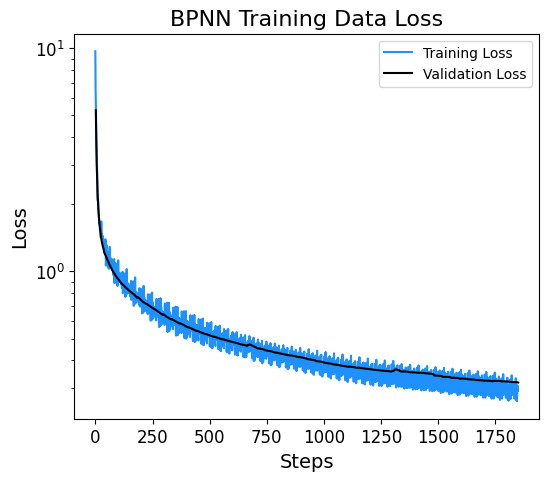

In [ ]:
data = pd.read_csv(f'logs_csv/lightning_logs/version_{csv_logger.version}/metrics.csv')
fig, ax = plt.subplots(figsize=(6,5))
x = data['epoch'][~data['epoch'].isnull()]
y = data['train_loss'][~data['train_loss'].isnull()]
print('Size of the Training Set:', len(y))
plt.semilogy(y, label='Training Loss',color='dodgerblue')
y = data['val_loss'][~data['val_loss'].isnull()]
print('Size of the Validation Set:', len(y))
plt.semilogy(y, label='Validation Loss',color='k')
plt.xlabel('Steps', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('BPNN Training Data Loss', fontsize=16)
plt.legend()
plt.show()